In [24]:
#Pandas, Numpy
import numpy as np
import pandas as pd

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Read file from URL
import requests

#sklearn models, Pipeline & Metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [36]:
"""Read the Dataset available from https://ibm.box.com/v/tabformer-data as a tar compressed file
Due to the limitation of the github and git lfs in persisting large file. A sample file of size 50,000 records are saved to
file transactions_sample.csv for this analysis."""

data = pd.read_csv('transactions_sample.csv')

SyntaxError: invalid syntax (926231822.py, line 2)

In [30]:
# Data Analysis
df.isnull().sum()

User                   0
Card                   0
Year                   0
Month                  0
Day                    0
Time                   0
Amount                 0
Use Chip               0
Merchant Name          0
Merchant City          0
Merchant State     56068
Zip                59294
MCC                    0
Errors?           492067
Is Fraud?              0
dtype: int64

In [31]:
#Fill missing values in the columns
#For all Online transactions, Merchant State and Zip is Nan. 
df['Merchant State'] = df['Merchant State'].fillna('ZZ')
df['Zip'] = df['Zip'].fillna(0)

#Since the error, column is irrelevant for this use-case, we can drop the column
df.drop(columns='Errors?', inplace=True)

#Remove the $ symbol from the amount and change the datatype to numeric 
#Also make it logarthimic, addressing refunds (negatives)
df['Amount'] = df['Amount'].apply(lambda x: x[1:]).astype(float).apply(lambda amt: max(1, amt)).apply(np.log)

#Rename the column 'Is Fraud?' to Fraud and also change it to int
df.rename(columns={'Is Fraud?': 'Fraud'}, inplace=True)
df['Fraud'] = df['Fraud'].apply(lambda x: 1 if x == 'Yes' else 0)

#Convert Year, Month, Date, Time to Pandas Datetime and Drop Columns - Year, Month, Day, Time
hour_min = df['Time'].str.split(':', expand=True)
df['Date'] = pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=df['Day'], hour=hour_min[0], minute=hour_min[1])).astype(int)
df.drop(columns= {'Year', 'Month', 'Day', 'Time'}, inplace=True)


In [32]:
df.isna().sum()

User              0
Card              0
Amount            0
Use Chip          0
Merchant Name     0
Merchant City     0
Merchant State    0
Zip               0
MCC               0
Fraud             0
Date              0
dtype: int64

In [33]:
df['Date']

18199893    1562717460000000000
9731325     1547503920000000000
536687      1268636820000000000
13223840    1442761080000000000
17070521    1413114240000000000
                   ...         
8796909     1549704240000000000
10461130    1472050080000000000
830853      1295962020000000000
6321131     1193831580000000000
6419258     1538439660000000000
Name: Date, Length: 500000, dtype: int64

In [8]:
#Card 
print (df['Card'].value_counts())

"""Based on the value of the Card feature, this does not provide any value. In the real-time scenarios card numbers are typically 
encrypted values and they can be used. For this dataset, we will drop the 'Card' column."""

#Since the card,  column is irrelevant for this use-case, we can drop the column
df.drop(columns='Card', inplace=True)

0    17782
1    13366
2     8810
3     5710
4     2692
5     1183
6      361
7       89
8        7
Name: Card, dtype: int64


In [9]:
# Merchant City
print (df['Merchant City'].value_counts())

 ONLINE             5702
Houston              531
Miami                375
Los Angeles          370
Brooklyn             307
                    ... 
Wabash                 1
West Hempstead         1
North Smithfield       1
Paso Robles            1
Elizabethport          1
Name: Merchant City, Length: 4044, dtype: int64


In [10]:

#pd.set_option("display.max_rows", 50, "display.max_columns", 50)
# Merchant State
#print (df['Merchant State'].value_counts())

"""For this project we will consider only States within the United States. For international transactions, we will 
decline those transactions before it reaches our ML model for decisioning"""

# Remove rows of data where the card transaction are coming from International countries.

# drop all rows that contains Countries listed in Merchant State
df.drop(df[df['Merchant State'].str.len() >2].index, inplace=True)

print (df['Merchant State'].value_counts())

ZZ    5702
CA    5343
TX    3706
FL    2993
NY    2805
OH    1821
IL    1806
PA    1749
NC    1612
GA    1351
NJ    1283
IN    1282
MI    1262
WA    1075
TN     983
VA     819
MA     758
MD     757
AL     751
MN     747
KY     725
SC     724
WI     699
AZ     695
OK     670
MO     666
CO     568
LA     551
IA     503
AR     498
MS     410
KS     382
CT     362
OR     348
NV     339
UT     318
NM     304
HI     300
WV     280
RI     251
NH     217
NE     203
ID     167
DE     162
ND     136
ME     132
VT     119
SD     116
MT     111
DC      40
WY      34
AK      33
Name: Merchant State, dtype: int64


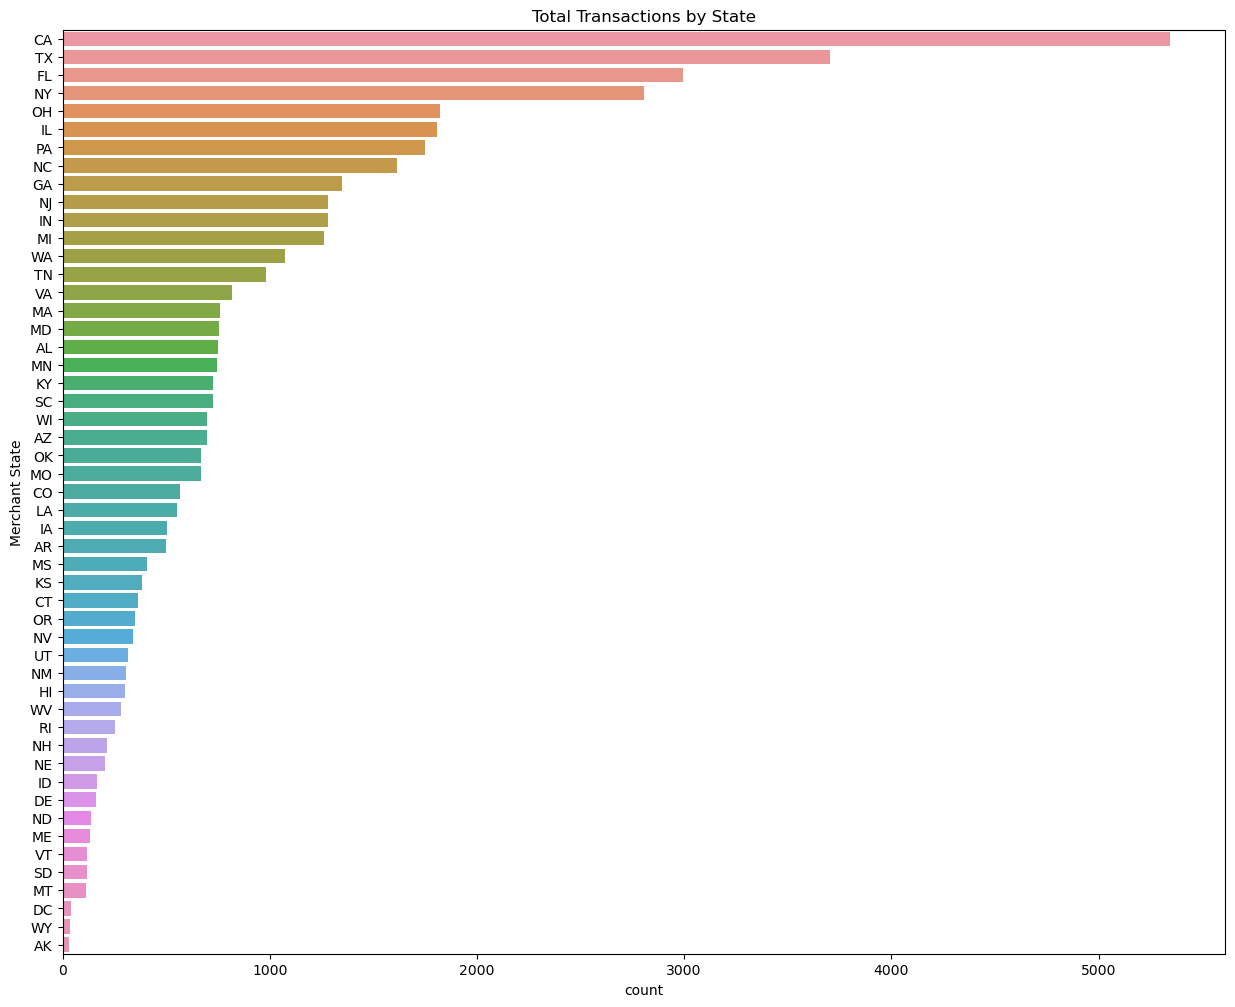

In [11]:
# Display Total transactions by state

#Drop online transactions alone 
df_disp = df.drop(df[df['Merchant State'].str.endswith('ZZ')].index)

plt.figure(figsize=(15, 12))  
sns.countplot(df_disp, y='Merchant State', order=df_disp['Merchant State'].value_counts().index, orient='h')
plt.title('Total Transactions by State')
plt.show()


In [12]:
X = df.drop(columns=['Fraud','Merchant City', 'Merchant State' ])
y = df['Fraud']

In [13]:
X, y

(          User    Amount            Use Chip        Merchant Name      Zip  \
 18199893  1470  4.080584    Chip Transaction -6853385250336487907  20776.0   
 9731325    822  5.638034  Online Transaction  4241336128694185533      0.0   
 536687      41  0.000000   Swipe Transaction   190253443608377572  92543.0   
 13223840  1084  1.911023    Chip Transaction -7837310524365334241  80122.0   
 17070521  1384  2.215937   Swipe Transaction -5023497618971072366  66030.0   
 ...        ...       ...                 ...                  ...      ...   
 11336609   941  4.017643  Online Transaction -4241409341442030551      0.0   
 12593218  1035  4.163404   Swipe Transaction -5162038175624867091  31021.0   
 13268801  1088  4.491441   Swipe Transaction -3345936507911876459  19701.0   
 9728444    822  4.608166   Swipe Transaction -7275194454407817045  10543.0   
 4383664    368  4.465908    Chip Transaction  1799189980464955940  21144.0   
 
            MCC                 Date  
 18199893  

In [14]:
df.isna().sum()

User              0
Amount            0
Use Chip          0
Merchant Name     0
Merchant City     0
Merchant State    0
Zip               0
MCC               0
Fraud             0
Date              0
dtype: int64

In [15]:
transformer_columns = ['Use Chip']
transformer = make_column_transformer((OneHotEncoder(drop='if_binary', handle_unknown='ignore'), transformer_columns), remainder=StandardScaler())

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = transformer.fit_transform(X)
X_test_scaled = transformer.fit(X_test)

In [17]:
#Logistic Regression explored for Credit Card Fraud Detection

pipe = Pipeline([('transformer', transformer),
                 ('lgr', LogisticRegression())])
lgr_param_grid = {   
    'lgr__penalty' : ['l2'],
    'lgr__C' : np.logspace(-4, 4, 20),
    'lgr__max_iter' : [100, 1000,2500, 5000]
}
lgr_grid = GridSearchCV(pipe, param_grid=lgr_param_grid, scoring='roc_auc', error_score='raise')
lgr_grid.fit(X_train, y_train)

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore'),
                                                                         ['Use '
                                                                          'Chip'])])),
                                       ('lgr', LogisticRegression())]),
             param_grid={'lgr__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'lgr__max_iter': [100, 1000, 2500, 5000],
                         'lgr__penalty': ['l2']},
             scoring='roc_auc')

In [18]:
print(lgr_grid.best_params_)
print(lgr_grid.best_estimator_)
print(lgr_grid.best_score_)

{'lgr__C': 29.763514416313132, 'lgr__max_iter': 100, 'lgr__penalty': 'l2'}
Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['Use Chip'])])),
                ('lgr', LogisticRegression(C=29.763514416313132))])
0.8797169245531965


In [19]:
#Support Vector Machines explored for Credit Card Fraud Detection

pipe2 = Pipeline([('transformer', transformer),
                 ('svm', SVC())])
# svm_param_grid = {
#     'svm__kernel' : ['linear', 'rbf', 'poly'],
#     'svm__gamma' : [0.1, 1, 10],
#     'svm__C' : [0.1, 1, 10],
#     'svm__degree' :[0, 1, 2, 3, 4, 5, 6]
# }

svm_param_grid = {
    'svm__kernel' : ['linear'],
    'svm__gamma' : [0.1, 1, 10],
    'svm__C' : [0.1, 1, 10],
    'svm__degree' :[0, 1, 2, 3]
}

svm_grid = GridSearchCV(pipe2, param_grid=svm_param_grid, scoring='roc_auc', error_score='raise')
svm_grid.fit(X_train, y_train)


GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore'),
                                                                         ['Use '
                                                                          'Chip'])])),
                                       ('svm', SVC())]),
             param_grid={'svm__C': [0.1, 1, 10], 'svm__degree': [0, 1, 2, 3],
                         'svm__gamma': [0.1, 1, 10],
                         'svm__kernel': ['linear']},
             scoring='roc_auc')

In [20]:
print(svm_grid.best_params_)
print(svm_grid.best_estimator_)
print(svm_grid.best_score_)

{'svm__C': 0.1, 'svm__degree': 0, 'svm__gamma': 0.1, 'svm__kernel': 'linear'}
Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['Use Chip'])])),
                ('svm', SVC(C=0.1, degree=0, gamma=0.1, kernel='linear'))])
0.8280664507616649


In [21]:
#Random Forest Classifier explored for Credit Card Fraud Detection

pipe3 = Pipeline([('transformer', transformer),
                 ('rfc', RandomForestClassifier())])
rfc_param_grid = {
    'rfc__n_estimators' : [100, 200],
    'rfc__criterion' : ['gini', 'entropy'],
    'rfc__max_features' : ['sqrt'],
     'rfc__max_depth' :[int(x) for x in np.linspace(10, 110, num = 11)],
    'rfc__min_samples_split' : [2, 5],
    'rfc__min_samples_leaf' : [1, 2]
}
    
rfc_grid = GridSearchCV(pipe3, param_grid=rfc_param_grid, scoring='roc_auc', error_score='raise')
rfc_grid.fit(X_train, y_train)




GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore'),
                                                                         ['Use '
                                                                          'Chip'])])),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                            100, 110],
                         'rfc__max_features': ['sqrt'],
                         'rfc__min_samples_leaf': [1, 2],
                         'rfc__min_samples_split': [2, 5],
                         'rfc__n_estimators': [100, 200]},
             scoring='roc_auc')

In [22]:
print(rfc_grid.best_params_)
print(rfc_grid.best_estimator_)
print(rfc_grid.best_score_)

{'rfc__criterion': 'entropy', 'rfc__max_depth': 40, 'rfc__max_features': 'sqrt', 'rfc__min_samples_leaf': 2, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 200}
Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  ['Use Chip'])])),
                ('rfc',
                 RandomForestClassifier(criterion='entropy', max_depth=40,
                                        min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=200))])
0.9277389948422694
